Boosted trees en TensorFlow
===

* *30 min* | Última modificación: Julio 12, 2019.

## Preparación

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## tf.enable_eager_execution()  <--- bloquea jupyter

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

## Datos

In [2]:
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Exploración

In [4]:
print(dftrain.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [5]:
print(dftrain.describe())

              age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200


In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

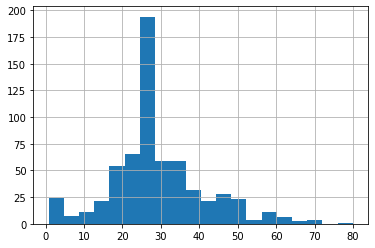

In [7]:
dftrain.age.hist(bins=20);

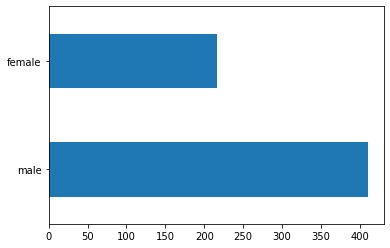

In [8]:
dftrain.sex.value_counts().plot(kind='barh');

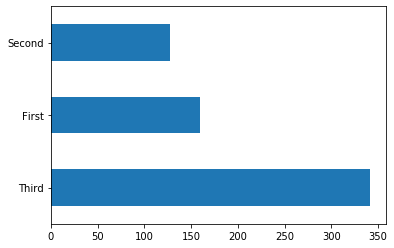

In [9]:
(dftrain['class']
  .value_counts()
  .plot(kind='barh'));

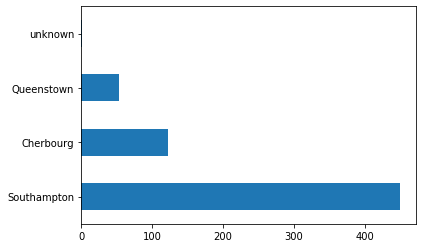

In [10]:
(dftrain['embark_town']
  .value_counts()
  .plot(kind='barh'));

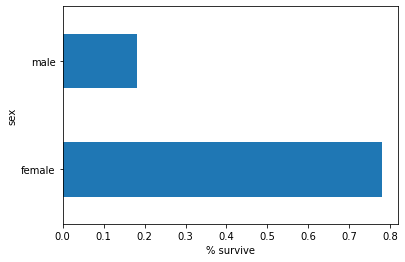

In [12]:
(pd.concat([dftrain, y_train], axis=1)
    .groupby('sex')
    .survived
    .mean()
    .plot(kind='barh'))
plt.xlabel('% survive');

## Preparación

In [13]:
fc = tf.feature_column

CATEGORICAL_COLUMNS = [
    'sex', 
    'n_siblings_spouses', 
    'parch', 
    'class', 
    'deck', 
    'embark_town', 
    'alone']

NUMERIC_COLUMNS = [
    'age', 
    'fare']
  
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name,
                                                   vocab))

In [14]:
feature_columns = []

In [15]:
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [16]:
  
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [17]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"


AttributeError: 'Tensor' object has no attribute 'numpy'

In [18]:
fc.input_layer(dict(example), feature_columns).numpy()

AttributeError: 'Tensor' object has no attribute 'numpy'

In [19]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):

    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)

        dataset = dataset.repeat(n_epochs)  
        
        dataset = dataset.batch(NUM_EXAMPLES)
        
        return dataset
    
    return input_fn


train_input_fn = make_input_fn(
    dftrain, 
    y_train)

eval_input_fn = make_input_fn(
    dfeval, 
    y_eval, 
    shuffle=False, 
    n_epochs=1)

## Entrenamiento del modelo

In [20]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

linear_est.train(
    train_input_fn, 
    max_steps=2)


results = linear_est.evaluate(eval_input_fn)

print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.719697
Dummy model:  0.625


In [21]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    n_batches_per_layer=n_batches)

est.train(
    train_input_fn, 
    max_steps=2)

results = est.evaluate(eval_input_fn)

print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.74242425
Dummy model:  0.625


In [22]:
##
## Manejo en memoria
##
def make_inmemory_train_input_fn(X, y):
    def input_fn():
        return dict(X), y
    return input_fn

In [23]:
train_input_fn = make_inmemory_train_input_fn(
    dftrain, 
    y_train)

In [24]:
eval_input_fn = make_input_fn(
    dfeval, 
    y_eval, 
    shuffle=False, 
    n_epochs=1)

In [ ]:
est = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(
    train_input_fn,
    feature_columns)

In [ ]:
print(est.evaluate(eval_input_fn)['accuracy'])

In [ ]:
pred_dicts = list(est.predict(eval_input_fn))

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);